# Hockey Statistics Analysis Overview 

Over time the sports world has begun creating more and more stats in order to track players' involvement in their respective games. Some fans and commentators of hockey feel that these new "advanced" analytics are unnecessary and not worth taking into account. I want to see which tracked statistics could be best used to predict the amount of points a player will accumulate. 

Point production will be a total of each player's goals, primary assists and secondary assists.
Let's take a look at the two advanced statistics we will be primarily focusing on, Corsi and Fenwick. It is worth noting that for the purpose of this analysis, we will be focusing on individual players at 5 on 5. Corsi and Fenwick are similar with one major difference. Corsi is a percentage based on how many shots a team took versus how many the opposing team took while the player we are tracking was on the ice. It is expressed as the following calculation: Corsi Percentage = (Team A / (Team A + Team B)) * 100. Feniwick, unlike Corsi, does not count shots that are blocked by the opposing team.

I would argue that the traditional stats category "Shots on Net" is a better predictor of actual point production. This is because in order for a shot to be counted in for this stat, the shot has to hit the goalie, or go in the net. Shots that hit the post are not counted.
What this says to me is that since the goalie has to make contact with the puck, there was a high chance without the goalie's intervention the puck would have gone in the net. I feel this stat also better predicts assists since a lot of goals are scored off of rebounds. I can speculate all day but let's dig into some data from the 2018-2020 seasons to see what it can tell us.

I will be using multiple data sets from the popular hockey stats website www.naturalstattrick.com

## Questions
1. Are advanced statistics (corsi, fenwick) better at predicting a players point production then traditional statistics?

2. Are there certain statistics that could show us what is making top defenseman sucessful at generating points


## Hypothesis 

1. Traditional statistics are better overall at predicting player production then the newer advanced statistics

2. Defenseman who score a large amount of points are excelling in certain stats compared to lower scoring defenseman

### Glossary 

* Elite Player - Player who has scored 100 or more points
* Top Player - Player who has scored 60-99 points
* Average Player - Player who has scored 40-59 points
* Low Player - Player who has scored less than 40 points 
* Corsi -  is an advanced statistic used in the game of ice hockey to measure shot attempt differential while at even strength play.



## Section 1 
### Importing Libraries and files 
I will be starting with two .csv files. There is a bit of overlap between the columns in the two tables. The reason for needing two tables is that one (df_points) contains some stats information but more importantly each player's point production. The other .CSV (df_stats) contains a more comprehensive list of stats but no actual points total. In the end I will need to eventually merge these tables together to get the big picture.

In [166]:
import numpy as np
import statsmodels.api as sm
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="darkgrid")

In [167]:
# Importing the two .csv into Pandas so I can work with them as Data Frames 

df_points = pd.read_csv('/Users/ch/Documents/Python/Player Points.csv')
df_stats = pd.read_csv('/Users/ch/Documents/Python/Player Stats.csv')


## Section 2


##### Data Frame Clean up / Manipulation

The first stage of my analysis will be to go through both data frames and remove columns that I won't need to for my visualizations and regression modelling. During this process I am preparing the tables to be merged. I am looking for duplicate columns as well as stats that don't' contribute to a players ability to score points i.e penalty minutes.

It is worth mentioning that I am removing pretty much all penalty related statistics. I think they could be of use if we were exploring point production on the Powerplay, since in theory if a player who played on the powerplay drew more penalties, they would have more time on the powerplay. This is for the next analysis :)


In [168]:
# Sorting df_points by total points in descending order
df_points_sorted = df_points.sort_values('Total Points', ascending = False) 


In [169]:
# Removing columns from points table to make final merged DF cleaner
df_points_sorted.drop(columns = ['Goals', 'Total Assists','First Assists','Second Assists','IPP'
                                 ,'ixG', 'iCF', 'iFF', 'iSCF', 'iHDCF', 'Total Penalties','Minor'
                                 ,'Major','Misconduct','Penalties Drawn','Takeaways', 'Hits Taken'
                                 ,'Faceoffs Won', 'Faceoffs Lost', 'Faceoffs %'], inplace = True) 

In [170]:
# Removing columns from stats table to make final merged DF cleaner
df_stats.drop(columns = ['Team', 'GP', 'TOI', 'CF', 'CA', 
               'FF', 'FA', 'SF', 'SA', 'GF', 'GA',
               'xGF', 'xGA', 'SCF', 'SCA', 'HDCF',
               'HDCA', 'MDCF','MDCA','MDGF', 'MDGA',
               'LDCF', 'LDCA', 'LDGF', 'LDGA', 'On-Ice SH%',
               'On-Ice SV%', 'PDO'], inplace = True)

In [171]:
# Renaming a few columns for easier readabilty
df_stats.rename(columns ={'Unnamed: 0':'Player_Id','Player':'Player_Name', 'CF%':'Corsi', 'FF%':'Fenwick'}, inplace = True)
df_points_sorted.rename(columns = {'Unnamed: 0':'Player_Id','Player':'Player_Name'}, inplace = True)

In [172]:
df_stats.head(6) #checking to make sure renaming/column removal was as intended 

,Player_Id,Player_Name,Position,Corsi,Fenwick,SF%,GF%,xGF%,SCF%,HDCF%,HDGF,HDGA,HDGF%,MDCF%,MDGF%,LDCF%,LDGF%,Off. Zone Starts,Neu. Zone Starts,Def. Zone Starts,On The Fly Starts,Off. Zone Start %,Off. Zone Faceoffs,Neu. Zone Faceoffs,Def. Zone Faceoffs,Off. Zone Faceoff %
0,317,Dalton Smith,L,100.00,100.00,100.00,100.00,100.00,100.00,-,0,0,-,100.00,-,100.00,100.00,1,1,0,2,100.00,1,1,0,100.00
1,1048,Parker Kelly,C,78.57,70.00,66.67,100.00,64.71,75.00,33.33,0,0,-,100.00,-,75.00,100.00,0,0,2,6,0.00,0,1,4,0.00
2,1017,Justin Kloos,C,75.00,80.00,100.00,-,85.59,75.00,100.00,0,0,-,50.00,-,66.67,-,0,0,0,10,-,2,0,1,66.67
3,1091,Jan Jenik,R,69.44,65.52,65.00,100.00,66.20,61.54,57.14,0,0,-,66.67,100.00,72.73,100.00,7,7,2,15,77.78,9,11,4,69.23
4,521,Kevin Roy,L,65.52,68.29,72.41,0.00,61.91,57.14,66.67,0,0,-,50.00,0.00,73.91,-,4,8,2,34,66.67,9,9,8,52.94
5,557,Kyle Burroughs,D,63.10,63.08,63.83,66.67,63.77,75.76,68.75,2,0,100.00,82.35,0.00,56.41,-,9,7,5,47,64.29,16,13,13,55.17


In [173]:
df_points_sorted.head(5) #checking to make sure renaming/column removal was as intended 

,Player_Id,Player_Name,Team,Position,GP,TOI,Total Points,Shots,SH%,Rush Attempts,Rebounds Created,PIM,Giveaways,Hits,Shots Blocked
2,752,Connor McDavid,EDM,C,198,3356.116667,170,429,14.92,26,42,52,160,119,63
3,659,Leon Draisaitl,EDM,C,209,3452.150000,155,352,17.90,29,35,60,199,114,47
8,167,Patrick Kane,CHI,R,207,3501.316667,152,523,10.71,27,42,44,107,52,49
14,815,Artemi Panarin,"CBJ, NYR","C, L",190,2955.233333,149,332,14.76,15,32,26,136,41,36
0,864,Auston Matthews,TOR,C,190,3037.966667,136,533,15.20,21,60,26,137,121,144


### Using merge to create master data frame 



In [174]:
master_df = pd.merge(df_points_sorted, df_stats) 


In [175]:
master_df.head(5)

,Player_Id,Player_Name,Team,Position,GP,TOI,Total Points,Shots,SH%,Rush Attempts,Rebounds Created,PIM,Giveaways,Hits,Shots Blocked,Corsi,Fenwick,SF%,GF%,xGF%,SCF%,HDCF%,HDGF,HDGA,HDGF%,MDCF%,MDGF%,LDCF%,LDGF%,Off. Zone Starts,Neu. Zone Starts,Def. Zone Starts,On The Fly Starts,Off. Zone Start %,Off. Zone Faceoffs,Neu. Zone Faceoffs,Def. Zone Faceoffs,Off. Zone Faceoff %
0,752,Connor McDavid,EDM,C,198,3356.116667,170,429,14.92,26,42,52,160,119,63,50.70,50.31,50.15,52.86,50.64,51.47,50.92,108,103,51.18,51.86,58.73,50.57,44.44,657,716,359,2034,64.67,1231,1036,856,58.98
1,659,Leon Draisaitl,EDM,C,209,3452.150000,155,352,17.90,29,35,60,199,114,47,48.83,48.68,48.57,54.10,49.23,48.69,47.42,94,103,47.72,49.57,61.67,49.39,61.22,638,701,520,1983,55.09,1183,1031,1058,52.79
2,167,Patrick Kane,CHI,R,207,3501.316667,152,523,10.71,27,42,44,107,52,49,47.29,46.19,46.13,55.04,44.20,45.61,40.49,95,95,50.00,48.96,61.61,49.28,60.00,606,691,280,2385,68.40,1173,1068,785,59.91
3,815,Artemi Panarin,"CBJ, NYR","C, L",190,2955.233333,149,332,14.76,15,32,26,136,41,36,52.17,52.68,52.70,61.39,53.49,53.29,51.12,97,56,63.40,54.67,57.01,51.07,66.67,617,660,268,1998,69.72,1077,928,602,64.15
4,864,Auston Matthews,TOR,C,190,3037.966667,136,533,15.20,21,60,26,137,121,144,53.58,53.19,53.36,56.77,55.25,56.28,58.11,103,72,58.86,55.17,55.17,50.65,51.22,645,743,362,2014,64.05,1137,1031,788,59.06


Everything looks good. We have succesfully removed what we won't need from the two tables and 
merged them together on each player's unique ID 

### Creating a new column 
I want to create a new column where I can group the players into 4 catergories: Elite, Top, Average, Low. The condition for which group the players find themselves in will be based on the Total Points Column. I feel that by getting an idea of how the players are spread out across this category will paint an interesting picture about how hard it is to get points in the NHL. It will also allow us to take a looks at how the different tiers compare to each other.

In [177]:
#This code block will provide the conditions and values for feature engineering our new column
conditions = [
    (master_df['Total Points'] >= 100),
    (master_df['Total Points'] >= 60),
    (master_df['Total Points'] >= 40),
    (master_df['Total Points'] < 40)
    ]
values = ['Elite', 'Top', 'Average', 'Low']

master_df['Player_Tier'] = np.select(conditions, values) # assigning our new values to a new column



In [178]:
pd.set_option('display.max_columns', None)
master_df.head(5)


,Player_Id,Player_Name,Team,Position,GP,TOI,Total Points,Shots,SH%,Rush Attempts,Rebounds Created,PIM,Giveaways,Hits,Shots Blocked,Corsi,Fenwick,SF%,GF%,xGF%,SCF%,HDCF%,HDGF,HDGA,HDGF%,MDCF%,MDGF%,LDCF%,LDGF%,Off. Zone Starts,Neu. Zone Starts,Def. Zone Starts,On The Fly Starts,Off. Zone Start %,Off. Zone Faceoffs,Neu. Zone Faceoffs,Def. Zone Faceoffs,Off. Zone Faceoff %,Player_Tier
0,752,Connor McDavid,EDM,C,198,3356.116667,170,429,14.92,26,42,52,160,119,63,50.70,50.31,50.15,52.86,50.64,51.47,50.92,108,103,51.18,51.86,58.73,50.57,44.44,657,716,359,2034,64.67,1231,1036,856,58.98,Elite
1,659,Leon Draisaitl,EDM,C,209,3452.150000,155,352,17.90,29,35,60,199,114,47,48.83,48.68,48.57,54.10,49.23,48.69,47.42,94,103,47.72,49.57,61.67,49.39,61.22,638,701,520,1983,55.09,1183,1031,1058,52.79,Elite
2,167,Patrick Kane,CHI,R,207,3501.316667,152,523,10.71,27,42,44,107,52,49,47.29,46.19,46.13,55.04,44.20,45.61,40.49,95,95,50.00,48.96,61.61,49.28,60.00,606,691,280,2385,68.40,1173,1068,785,59.91,Elite
3,815,Artemi Panarin,"CBJ, NYR","C, L",190,2955.233333,149,332,14.76,15,32,26,136,41,36,52.17,52.68,52.70,61.39,53.49,53.29,51.12,97,56,63.40,54.67,57.01,51.07,66.67,617,660,268,1998,69.72,1077,928,602,64.15,Elite
4,864,Auston Matthews,TOR,C,190,3037.966667,136,533,15.20,21,60,26,137,121,144,53.58,53.19,53.36,56.77,55.25,56.28,58.11,103,72,58.86,55.17,55.17,50.65,51.22,645,743,362,2014,64.05,1137,1031,788,59.06,Elite


### High Level Statistical Analysis 
Now that I am happy with how my data frame is looking. I want to take a quick look at some statistics to see if we can find any interesting patterns to focus in on

In [126]:
#Average/Median Points total 
print(round(master_df['Total Points'].mean(),))
print(round(master_df['Total Points'].median(),))

29
18


In [127]:
#Average/Median Amount of Games Played 
print(round(master_df['GP'].mean(),))
print(round(master_df['GP'].median(),))

98
91


Taking a look at some of the means and medians it is pretty clear that the majority of players occupy our "Low" category. This really does paint a picture of just how dominant the players at the top of the NHL are. I found it interesting that the mean amount of games played was only around 100. There could be a few reasons for this. One Covid. The 2019-2020 season was cut short due to the pandemic. It is also likely that a majority of players don't play a full season. This is expected due to injuries and line up changes, but I would have thought that the mean number overal would have been higher. 

Next, let's take a look at a breakdown of player positions. 

<AxesSubplot:xlabel='Position'>

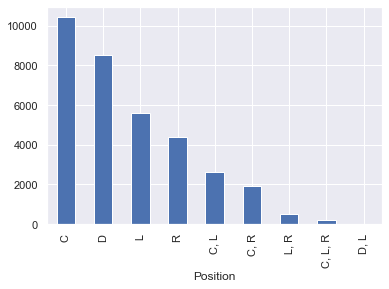

In [128]:
#Points Totals Grouped By Position
master_df.groupby(['Position'])['Total Points'].agg('sum').sort_values(ascending = False).plot.bar()

One interesting thing I am noticing here is that the Centre position is really leading the way in terms of point production. It is a bit odd to see defenseman with the second highest amount of points.
My suspicion is that the defense position is a little inflated by how many defenseman there are in the league at a given time. Now you might be asking, aren't the wingers' totals a bit stunted since they are split into two different groups? I considered combining them, but since this is for an audience of Fantasy Hockey players, I felt it made more sense to leave them in separate groups.
Fantasy Hockey requires you to select a specific amount of each position, seeing the break down can give you a better idea of how points are spread across the two positions.Lets take a look at a visualization of how the position breaks down across the Data Frame, to see if my hypothesis about the defenseman is true.
 

Text(0.5, 1.0, 'Number of Players by Position')

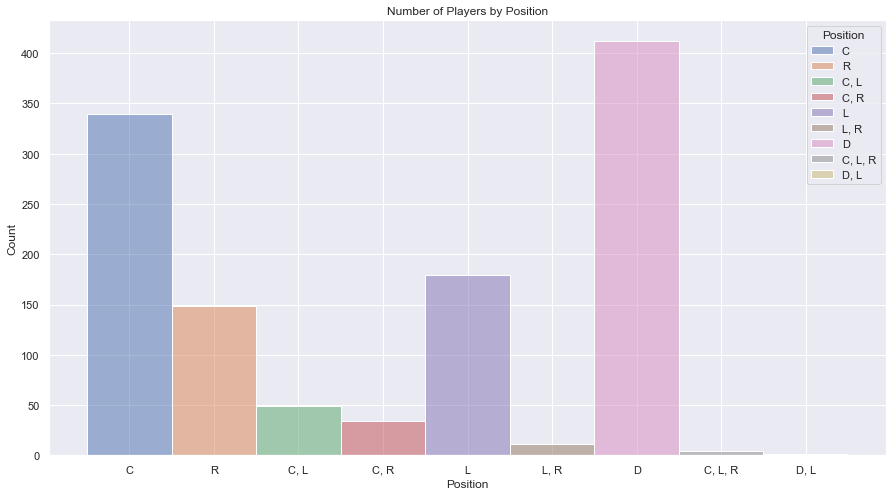

In [179]:
plt.figure(figsize=(15,8))
sns.histplot(data = master_df, x = 'Position', hue = 'Position', stat = 'count').set_title('Number of Players by Position')

From looking at how the position is distributed across the players, defenseman do seem to lead the way in the amount of players. It is worth noting that although a team on a given night will usually consist of more forwards than defenseman, the nature of defenceman's role in the game is one that makes them more prone to injury. It is highly likely that teams will be required to rotate many different defenseman through their line up during a season. This would lead to the position representing a larger percentage of all the players in a given year. Even if I did combine the left and right wingers, there would still be more defenseman then any other position.
Defenseman will be something that we revisit later in the analysis. From a fantasy hockey standpoint, "offensive defenseman" are rare. It is important to target defenseman early in draft since only a handful are fantasy relevant


## Section 3 
### Scatterplots  

One of my goals with this analysis is to try to figure out what tracked statistics are most correlated to point production. Making use of scatter plots. Lets take a look at the correlation between certain stats and total point production. I will also bucket the players into the "Player Tier" categories I created earlier in the analysis. I am going to focus on mainly shots on goal, corsi and fenwick. This is due to the fact that they all have to do with shooting the puck

### Time on Ice Vs Total Points 

Text(0, 0.5, 'Time On Ice')

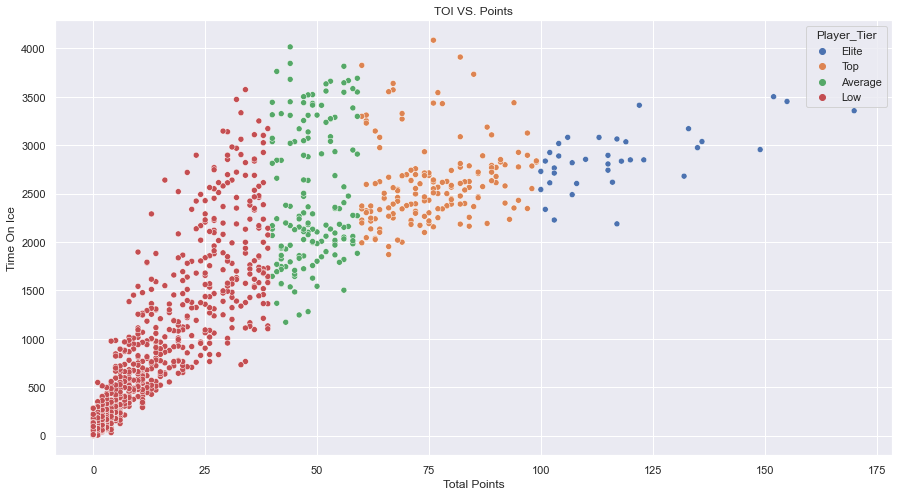

In [130]:
plt.figure(figsize=(15,8))
sns.scatterplot(data=master_df, x='Total Points', y='TOI', hue = 'Player_Tier')
plt.title('TOI VS. Points')
plt.ylabel('Time On Ice')

I want to start with Time on Ice since it would logically make sense the more time a player spends on the ice the better the odds of scoring a point. We can see a correlation between these two variables, but that is to be expected. It is interesting to point out that there are a lot of players in the "low" and "average" categories that have more ice time then some of the "elite" players. This shows that more ice time does not equal more points. If you take a look at the data frame below, you will see the top 20 players in terms of time on ice. One thing that stands out is that all of them are defenseman.If we were to select players for our fantasy team strictly based on TOI, we might be in trouble. 

In [331]:
top_toi = master_df.sort_values('TOI', ascending = False)
top_toi.head(21)

,Player_Id,Player_Name,Team,Position,GP,TOI,Total Points,Shots,SH%,Rush Attempts,Rebounds Created,PIM,Giveaways,Hits,Shots Blocked,Corsi,Fenwick,SF%,GF%,xGF%,SCF%,HDCF%,HDGF,HDGA,HDGF%,MDCF%,MDGF%,LDCF%,LDGF%,Off. Zone Starts,Neu. Zone Starts,Def. Zone Starts,On The Fly Starts,Off. Zone Start %,Off. Zone Faceoffs,Neu. Zone Faceoffs,Def. Zone Faceoffs,Off. Zone Faceoff %,Player_Tier
110,620,Darnell Nurse,EDM,D,209,4084.983333,76,435,5.52,17,29,100,146,411,288,48.50,47.91,48.08,49.75,48.68,49.09,48.43,102,117,46.58,49.53,60.33,48.08,37.50,484,823,485,2680,49.95,1242,1306,1210,50.65,Top
324,185,Drew Doughty,L.A,D,205,4015.733333,44,210,0.48,9,39,76,169,315,217,48.88,48.23,48.25,44.29,47.59,47.35,48.78,80,87,47.90,46.41,39.29,49.59,37.04,544,915,592,2447,47.89,1267,1440,1337,48.66,Average
86,793,Thomas Chabot,OTT,D,190,3911.750000,82,384,5.47,18,47,74,199,210,239,49.19,49.22,48.43,47.47,50.23,50.08,51.01,115,101,53.24,49.43,37.61,47.86,44.68,522,789,516,2542,50.29,1178,1278,1292,47.69,Top
88,39,Brent Burns,S.J,D,208,3910.650000,82,454,3.96,11,92,64,185,163,236,52.28,51.43,51.17,48.94,51.80,51.34,52.21,113,107,51.36,50.70,44.44,52.76,46.55,557,792,415,2766,57.30,1267,1331,1108,53.35,Top
325,805,Ivan Provorov,PHI,D,207,3845.300000,44,292,5.48,12,36,56,166,227,269,49.53,49.79,50.25,48.52,50.44,49.89,51.15,102,87,53.97,49.05,43.00,49.70,39.58,504,929,636,2577,44.21,1010,1331,1304,43.65,Average
200,30,Ryan Suter,MIN,D,207,3824.933333,60,231,4.33,5,40,44,62,140,210,50.26,50.03,50.07,51.29,54.02,53.33,56.92,98,97,50.26,50.72,55.34,47.53,46.94,574,773,459,2322,55.57,1357,1312,1190,53.28,Top
224,1001,Miro Heiskanen,DAL,D,205,3815.500000,56,342,4.39,13,36,30,180,111,152,50.85,50.86,51.81,50.77,53.12,54.36,54.19,79,77,50.64,54.49,51.79,48.57,51.06,627,823,599,2533,51.14,1274,1206,1189,51.73,Average
348,495,Esa Lindell,DAL,D,207,3762.333333,41,245,3.67,9,34,37,151,309,260,47.41,46.86,47.45,50.37,49.07,49.25,51.09,78,72,52.00,48.02,51.43,45.33,44.00,546,872,620,2571,46.83,1106,1239,1336,45.29,Average
71,202,Roman Josi,NSH,D,199,3733.133333,85,465,4.95,16,52,81,119,112,267,52.40,52.79,52.45,54.49,52.38,52.93,52.42,105,77,57.69,53.25,59.74,52.50,37.25,617,811,541,2399,53.28,1269,1198,1156,52.33,Top
204,260,Dmitry Orlov,WSH,D,202,3691.883333,59,241,4.98,9,26,72,147,301,203,51.02,50.80,50.35,51.20,50.02,51.43,47.52,83,104,44.39,54.27,58.82,51.37,61.67,500,753,438,2195,53.30,1121,1204,1043,51.80,Average


### Shots on Goal vs Total Points 

Next we are going to take a look at the stat I feel will be the best predictor for point production, shots on goal. Like I mentioned in the intro, in order to count as a shot on goal, it either has to hit the goalie or go in the net. Shots that hit the post do not count. Since the goalie is being required to make a save, that would imply that without the goalie there, the puck would have gone in the net. I feel that players who are more successful at generating these high risk scoring opportunities are going to score more points. Let's take a look at some data.


Text(0.5, 1.0, 'Shots On Net VS. Points')

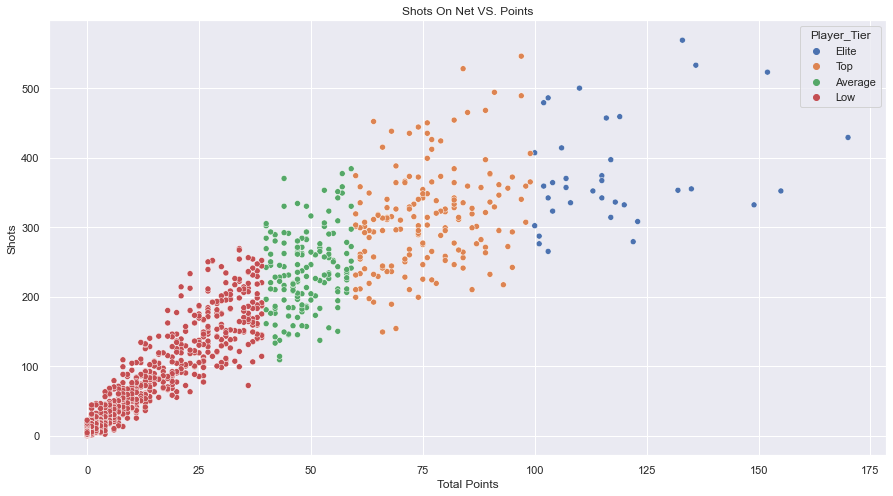

In [77]:
plt.figure(figsize=(15,8))
sns.scatterplot(data=master_df, x='Total Points', y='Shots', hue='Player_Tier')
plt.title('Shots On Net VS. Points')



As I expected there is a pretty strong correlation between shots on net and point production. It is interesting that the data points for each category are getting more and more spread out as we increase the amount of points scored. It is clear though that the players who get more shots on net are occupying the 'elite' and 'top' player tiers. I have a theory on why the "elite" players data points are so spread out. It has to do with the hockey term "Playmaker". Players can be grouped into different categories to describe their playing style. Play Makers are usually of the mindset pass over shoot. They are looking to set up their teammates for goals and get most of their points in the form of primary and secondary assists. Therefore, they could take less shots on goal and still generate points. Lets hone in these top players and see if these play makers are responsible for the spread out data points.



In [236]:
#I want to work with our original Player Points file to create a new Data Frame specific to how 
#the players points are divided between assists and goals
elite_players = pd.read_csv('/Users/ch/Documents/Python/Player Points.csv')

In [238]:
elite_players.drop(columns = ['Unnamed: 0', 'Team','Position','GP', 'TOI', 'IPP', 'SH%',
                               'ixG', 'iCF', 'iFF', 'iSCF', 'iHDCF', 'Rush Attempts',
                               'Rebounds Created','PIM', 'Total Penalties', 'Minor', 'Major',
                               'Misconduct', 'Penalties Drawn', 'Giveaways', 'Takeaways',
                               'Hits', 'Hits Taken','Shots Blocked', 'Faceoffs Won','Faceoffs Lost',
                               'Faceoffs %'], inplace = True)

In [264]:
# Replicating the feature engineering I did in my main table to sort out players into tiers
conditions2 = [
    (elite_players['Total Points'] >= 100),
    (elite_players['Total Points'] >= 60),
    (elite_players['Total Points'] >= 40),
    (elite_players['Total Points'] < 40)
    ]
values2 = ['Elite', 'Top', 'Average', 'Low']

elite_players['Player_Tier'] = np.select(conditions2, values2)

In [298]:
# Removing all players who are not in the elite catergory 
elite_players = elite_players.loc[elite_players['Player_Tier']== 'Elite']
elite_players.reset_index(drop = True, inplace = True)

In [314]:
# Creating a new column to bucket players into "snipers" and "play makers"
elite_players.loc[elite_players['Goals'] > elite_players['Total Assists'], 'Player_Type'] = 'Sniper'
elite_players.loc[elite_players['Goals'] < elite_players['Total Assists'], 'Player_Type'] = 'Play Maker'     

Text(0.5, 1.0, 'Shots Vs Point Production (Elite Player Types)')

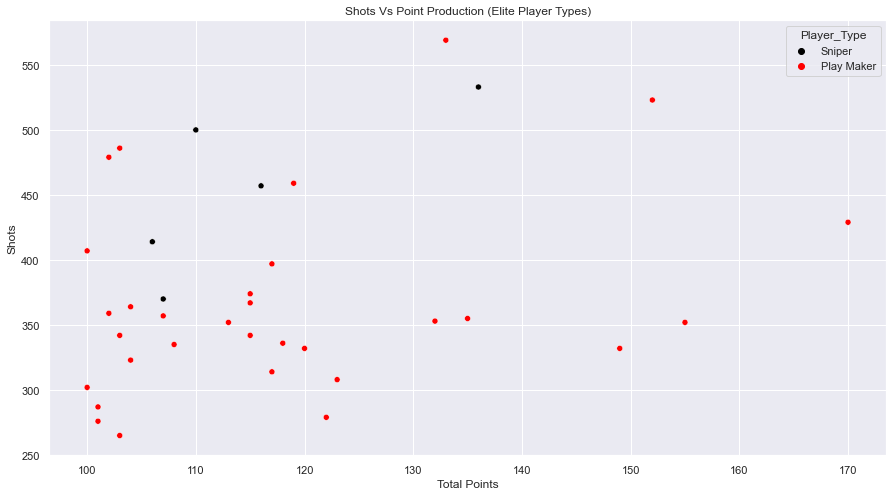

In [326]:
plt.figure(figsize=(15,8))
sns.scatterplot(data = elite_players, x = 'Total Points', y = 'Shots', hue = 'Player_Type'
                , palette = ['black', 'red'])
plt.title('Shots Vs Point Production (Elite Player Types)')

It looks like the majority of our "Elite" players are generating more of their points from assists then goals as suspected. To be honest this make sense since in todays NHL, goals are getting harder to score. Players need to accumilate a lot of assists to propel them to Elite status.

### Corsi and Fenwick Ratings in Relation to Point Production

My hypothesis was that the advance stats corsi and fenwick would not be as good at predicting a players point production as traditional stats. Lets see if we can plot some data to make a case for the hypothesis.

Text(0.5, 1.0, 'Corsi Rating VS. Points')

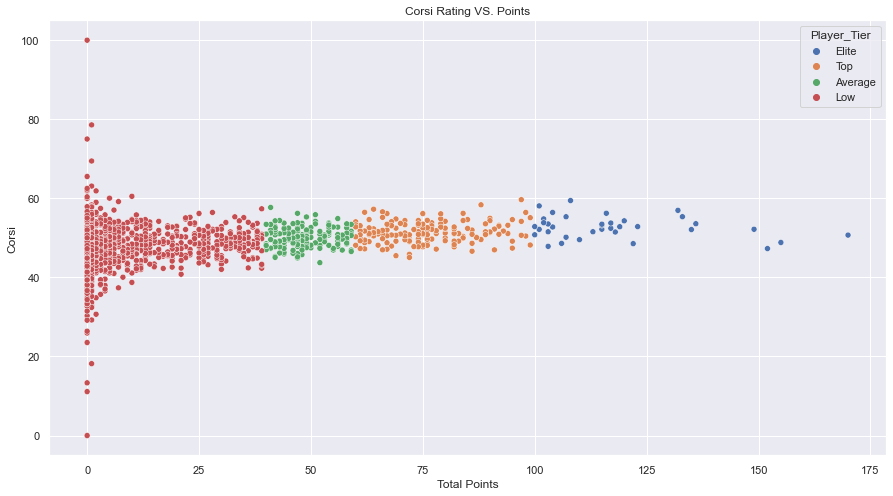

In [131]:
plt.figure(figsize=(15,8))
sns.scatterplot(data=master_df, x='Total Points', y='Corsi', hue='Player_Tier')
plt.title('Corsi Rating VS. Points')

Text(0.5, 1.0, 'Fenwick Rating VS. Points')

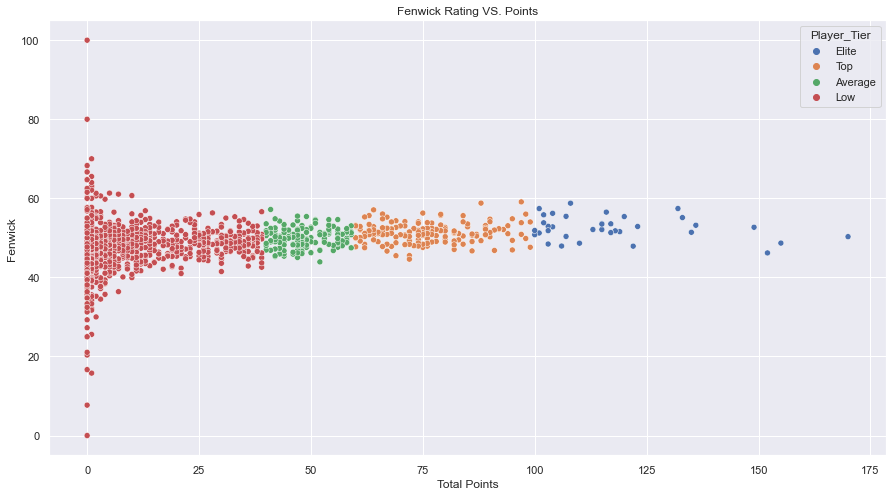

In [78]:
plt.figure(figsize=(15,8))
sns.scatterplot(data=master_df, x='Total Points', y='Fenwick', hue='Player_Tier')
plt.title('Fenwick Rating VS. Points')


It is very interesting how similar the corsi and fenwick scores are across the league. We don't really see a high corsi or fenick score correlating with point production. Unlike when we look at a traditional stat like shots on goal. It is pretty clear that the elite/top category players are getting more shots on net. It is likely that the positive and negative outliers in the "low" category is being caused by these players only playing a few games. A good or bad game would have a greater impact on their total Corsi/Fenwick numbers 


## Section 5
### Correlations & Linear Regression Model

Let's take a look at how the different stats correlate with the total points column. From here we can find out which statistics we want to plug into the linear regression model. 

In [57]:
regression_data = master_df[['Total Points','TOI','Shots','SH%','Rush Attempts','Rebounds Created','PIM','Giveaways','Hits','Shots Blocked','Corsi', 'Fenwick','SF%','GF%','xGF%','SCF%','HDCF%','HDGF','HDGA','HDGF%','MDCF%','MDGF%','LDCF%','LDGF%']]
regression_data.cor()

,Total Points,TOI,Shots,Rush Attempts,Rebounds Created,PIM,Giveaways,Hits,Shots Blocked,Corsi,Fenwick,SF%,xGF%,SCF%,HDGF,HDGA,MDCF%
Total Points,1.000000,0.837536,0.922245,0.851423,0.859149,0.629957,0.763814,0.455926,0.468302,0.312244,0.286446,0.264080,0.297817,0.317259,0.886598,0.831958,0.259480
TOI,0.837536,1.000000,0.907834,0.735506,0.867117,0.758110,0.899447,0.636888,0.822073,0.287290,0.268563,0.253220,0.292661,0.305384,0.962394,0.968582,0.232390
Shots,0.922245,0.907834,1.000000,0.892355,0.939710,0.712837,0.808555,0.584511,0.603810,0.322658,0.299973,0.279564,0.310899,0.325669,0.908119,0.884788,0.257442
Rush Attempts,0.851423,0.735506,0.892355,1.000000,0.828539,0.589356,0.649367,0.487351,0.369270,0.274138,0.252761,0.232150,0.262856,0.275757,0.743799,0.721380,0.219335
Rebounds Created,0.859149,0.867117,0.939710,0.828539,1.000000,0.694330,0.773629,0.578569,0.601416,0.327565,0.303075,0.281411,0.326502,0.334990,0.870746,0.848060,0.257641
PIM,0.629957,0.758110,0.712837,0.589356,0.694330,1.000000,0.694711,0.748485,0.614334,0.214867,0.210598,0.193448,0.233650,0.230970,0.722934,0.732331,0.163322
Giveaways,0.763814,0.899447,0.808555,0.649367,0.773629,0.694711,1.000000,0.508712,0.761062,0.259692,0.234348,0.218488,0.249276,0.265804,0.893012,0.893007,0.213722
Hits,0.455926,0.636888,0.584511,0.487351,0.578569,0.748485,0.508712,1.000000,0.556629,0.143039,0.150997,0.146220,0.188287,0.177761,0.565253,0.597292,0.099750
Shots Blocked,0.468302,0.822073,0.603810,0.369270,0.601416,0.614334,0.761062,0.556629,1.000000,0.166410,0.171468,0.166700,0.202495,0.199496,0.766115,0.788357,0.133925
Corsi,0.312244,0.287290,0.322658,0.274138,0.327565,0.214867,0.259692,0.143039,0.166410,1.000000,0.934394,0.860659,0.815210,0.834797,0.316340,0.257719,0.697176


After looking at how our stats correlate with each other, we are continuing to make a strong case that corsi and fenwick are not a good indicator for point production. If we take a look at the correlation for shots on net we are seeing a strong 0.9222%. When we compare this to corsi at 0.312% and fenwick at 0.286% it is pretty convincing. Let's take a look at how the different stats correlate with the total points column. From here we can find out which statistics we want to plug into the linear regression model.

In [136]:
dependent_vars = regression_data['Total Points']
independent_vars = regression_data[['TOI','Shots','PIM','Giveaways','Hits','Shots Blocked','Corsi', 'Fenwick','SF%','xGF%','SCF%','MDCF%']]

In [137]:
lin_reg = sm.OLS(dependent_vars, independent_vars)
reg_results = lin_reg.fit() #fit the model to the data using the fit method
print(reg_results.summary())

                                 OLS Regression Results                                
Dep. Variable:           Total Points   R-squared (uncentered):                   0.946
Model:                            OLS   Adj. R-squared (uncentered):              0.946
Method:                 Least Squares   F-statistic:                              1717.
Date:                Mon, 29 Nov 2021   Prob (F-statistic):                        0.00
Time:                        13:17:01   Log-Likelihood:                         -4359.8
No. Observations:                1179   AIC:                                      8744.
Df Residuals:                    1167   BIC:                                      8804.
Df Model:                          12                                                  
Covariance Type:            nonrobust                                                  
                    coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------

The first attempt at the model is showing some promise. The r^2 values are high, but we can see that some of our varibles have pretty high p values. Lets drop some of those and run another model.

In [142]:
indep2 = independent_vars = regression_data[['TOI','Shots','Giveaways','Hits','Shots Blocked']]

lin_reg2 = sm.OLS(dependent_vars, indep2)
regression2 = lin_reg2.fit()

print(regression2.summary())

                                 OLS Regression Results                                
Dep. Variable:           Total Points   R-squared (uncentered):                   0.946
Model:                            OLS   Adj. R-squared (uncentered):              0.946
Method:                 Least Squares   F-statistic:                              4093.
Date:                Mon, 29 Nov 2021   Prob (F-statistic):                        0.00
Time:                        13:25:07   Log-Likelihood:                         -4366.8
No. Observations:                1179   AIC:                                      8744.
Df Residuals:                    1174   BIC:                                      8769.
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
                    coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------

## Section 6
### Defenceman
I would like to see if the top scoring defenceman are excelling in specific stats compared to the defenceman in the "average" and "low" groups. First I am going to create a new data frame with just the defenceman.

In [329]:
defense = master_df.loc[master_df['Position'] == 'D']
defense.reset_index(drop = True, inplace = True )

In [333]:
defense.head(11)

,Player_Id,Player_Name,Team,Position,GP,TOI,Total Points,Shots,SH%,Rush Attempts,Rebounds Created,PIM,Giveaways,Hits,Shots Blocked,Corsi,Fenwick,SF%,GF%,xGF%,SCF%,HDCF%,HDGF,HDGA,HDGF%,MDCF%,MDGF%,LDCF%,LDGF%,Off. Zone Starts,Neu. Zone Starts,Def. Zone Starts,On The Fly Starts,Off. Zone Start %,Off. Zone Faceoffs,Neu. Zone Faceoffs,Def. Zone Faceoffs,Off. Zone Faceoff %,Player_Tier
0,200,John Carlson,WSH,D,201,3438.916667,94,356,7.30,13,38,42,134,128,245,51.10,51.05,51.24,55.65,49.89,50.58,48.10,97,103,48.50,52.34,61.39,52.80,70.49,571,823,442,2137,56.37,1322,1299,1074,55.18,Top
1,202,Roman Josi,NSH,D,199,3733.133333,85,465,4.95,16,52,81,119,112,267,52.40,52.79,52.45,54.49,52.38,52.93,52.42,105,77,57.69,53.25,59.74,52.50,37.25,617,811,541,2399,53.28,1269,1198,1156,52.33,Top
2,793,Thomas Chabot,OTT,D,190,3911.750000,82,384,5.47,18,47,74,199,210,239,49.19,49.22,48.43,47.47,50.23,50.08,51.01,115,101,53.24,49.43,37.61,47.86,44.68,522,789,516,2542,50.29,1178,1278,1292,47.69,Top
3,39,Brent Burns,S.J,D,208,3910.650000,82,454,3.96,11,92,64,185,163,236,52.28,51.43,51.17,48.94,51.80,51.34,52.21,113,107,51.36,50.70,44.44,52.76,46.55,557,792,415,2766,57.30,1267,1331,1108,53.35,Top
4,466,Morgan Rielly,TOR,D,184,3429.583333,78,338,5.92,9,25,46,183,148,195,51.10,50.57,49.51,56.93,51.59,52.81,52.30,107,89,54.59,53.14,59.79,49.25,60.87,576,729,476,2428,54.75,1245,1123,1051,54.22,Top
5,259,Tyson Barrie,"COL, EDM, TOR",D,204,3543.616667,77,426,4.46,11,46,52,135,114,210,52.15,51.59,51.54,51.49,50.76,51.25,49.96,73,89,45.06,52.11,57.26,53.17,56.25,638,703,393,2410,61.88,1386,1076,923,60.03,Top
6,91,Kris Letang,PIT,D,181,3435.133333,76,399,5.26,15,49,56,142,253,214,52.08,52.07,52.53,56.62,51.53,52.84,50.81,101,85,54.30,54.30,60.00,51.56,58.33,509,827,424,2315,54.56,1169,1266,1050,52.68,Top
7,620,Darnell Nurse,EDM,D,209,4084.983333,76,435,5.52,17,29,100,146,411,288,48.50,47.91,48.08,49.75,48.68,49.09,48.43,102,117,46.58,49.53,60.33,48.08,37.50,484,823,485,2680,49.95,1242,1306,1210,50.65,Top
8,55,Mark Giordano,CGY,D,194,3271.383333,69,364,4.67,12,44,68,105,124,260,54.78,54.33,53.30,57.60,54.27,54.13,52.78,87,67,56.49,55.01,59.55,54.72,60.53,509,764,562,2356,47.53,1139,1143,1126,50.29,Top
9,174,Jake Muzzin,"L.A, TOR",D,186,3327.433333,69,296,5.41,7,30,88,188,348,242,52.45,52.64,53.36,57.29,53.38,53.39,52.49,94,72,56.63,53.93,60.81,51.45,55.56,358,723,489,2571,42.27,903,1124,1054,46.14,Top


First lets take a look at how the defenseman are spread across our tier ranking. 

In [332]:
defense.groupby('Player_Tier').size()

Player_Tier
Average     63
Low        328
Top         21
dtype: int64

In [335]:
21/412 * 100

5.097087378640777

In [340]:
master_df.groupby('Player_Tier').size()

Player_Tier
Average    159
Elite       36
Low        818
Top        166
dtype: int64

In [342]:
36/1129 * 100

3.188662533215235

Like elite players across all players, top defenseman make up a small fraction of all defenseman. Lets take a look at some data to see if we can find anything the top defenseman are excelling in compared to their counterparts

In [364]:
# Making groups based on tiers to check with .descibe()
Top_Defenseman = defense.loc[defense['Player_Tier'] == "Top"]
Average_Defenseman = defense.loc[defense['Player_Tier'] == "Average"]
Low_Defenseman = defense.loc[defense['Player_Tier'] == "Low"]

In [347]:
Top_Defenseman.describe()

,Player_Id,GP,TOI,Total Points,Shots,Rush Attempts,Rebounds Created,PIM,Giveaways,Hits,Shots Blocked,Corsi,Fenwick,SF%,xGF%,SCF%,HDGF,HDGA,MDCF%,Off. Zone Starts,Neu. Zone Starts,Def. Zone Starts,On The Fly Starts,Off. Zone Faceoffs,Neu. Zone Faceoffs,Def. Zone Faceoffs,Off. Zone Faceoff %
count,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.00000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000
mean,355.190476,192.809524,3474.722222,70.571429,351.238095,13.142857,42.666667,62.095238,136.142857,189.809524,220.428571,52.664762,52.523333,52.397143,52.843333,52.984762,94.904762,82.47619,53.327619,510.285714,735.666667,458.666667,2398.952381,1164.476190,1153.380952,1056.904762,52.396667
std,280.536917,12.331338,294.741073,9.662150,76.455807,5.579298,15.847187,18.627680,44.790943,95.938845,33.335524,2.231315,2.248983,2.361062,2.353526,2.312379,10.231836,17.19773,2.454194,68.791092,72.316895,57.967520,195.627318,128.092006,113.970380,112.040575,3.166274
min,30.000000,166.000000,2974.583333,60.000000,219.000000,5.000000,24.000000,36.000000,62.000000,62.000000,160.000000,48.500000,47.910000,48.080000,48.680000,49.090000,73.000000,56.00000,49.430000,358.000000,596.000000,377.000000,1975.000000,903.000000,977.000000,898.000000,46.140000
25%,174.000000,184.000000,3271.383333,63.000000,299.000000,10.000000,33.000000,46.000000,105.000000,121.000000,194.000000,51.820000,51.430000,51.240000,51.270000,51.250000,91.000000,68.00000,51.640000,478.000000,694.000000,422.000000,2306.000000,1077.000000,1076.000000,967.000000,50.650000
50%,249.000000,194.000000,3435.133333,67.000000,356.000000,12.000000,39.000000,56.000000,134.000000,149.000000,216.000000,52.280000,52.400000,52.450000,52.560000,53.020000,94.000000,77.00000,53.250000,504.000000,745.000000,442.000000,2399.000000,1160.000000,1141.000000,1054.000000,52.610000
75%,590.000000,203.000000,3638.300000,77.000000,415.000000,16.000000,47.000000,76.000000,180.000000,241.000000,242.000000,53.080000,53.020000,53.360000,54.020000,54.040000,101.000000,97.00000,54.800000,571.000000,792.000000,489.000000,2542.000000,1267.000000,1266.000000,1126.000000,54.050000
max,914.000000,209.000000,4084.983333,94.000000,465.000000,31.000000,92.000000,100.000000,236.000000,411.000000,288.000000,57.250000,57.080000,56.970000,57.690000,57.460000,115.000000,117.00000,58.420000,638.000000,827.000000,570.000000,2766.000000,1386.000000,1331.000000,1292.000000,60.030000


Using .describe() I took a look at some averages across each defenseman tier. I just included the analysis for Top defenseman to reduce clutter. Some stats that stood out to me were: Shots, Hits and Rebounds Created. Lets visualize these findings. 

### Shots on Goal

Text(0.5, 0, 'Player Tier')

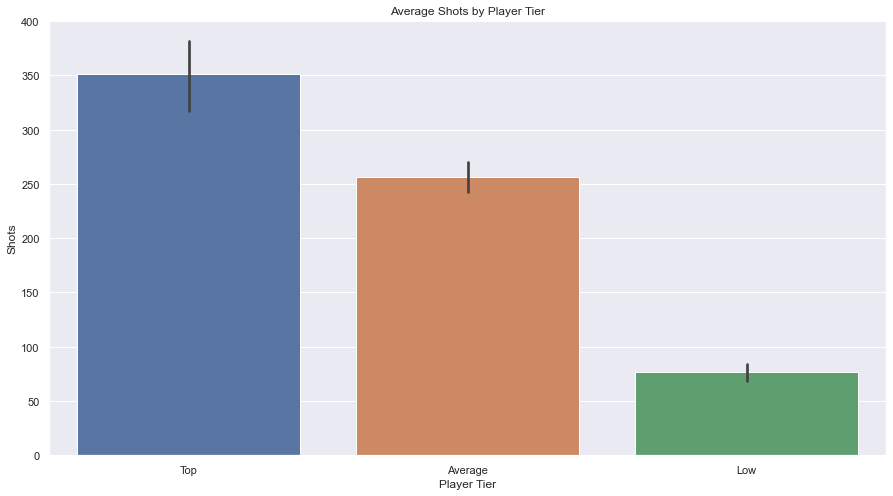

In [358]:
plt.figure(figsize=(15,8))
sns.barplot(data=defense, x='Player_Tier', y='Shots').set(title='Average Shots by Player Tier')
plt.xlabel('Player Tier')

It looks like the Top tier defenseman are taking more shots on net then the average and low defenseman. There ability to get shots through and on net are definitly going to improve their chances of scoring. 

### Rebounds Created 

Text(0.5, 0, 'Player Tier')

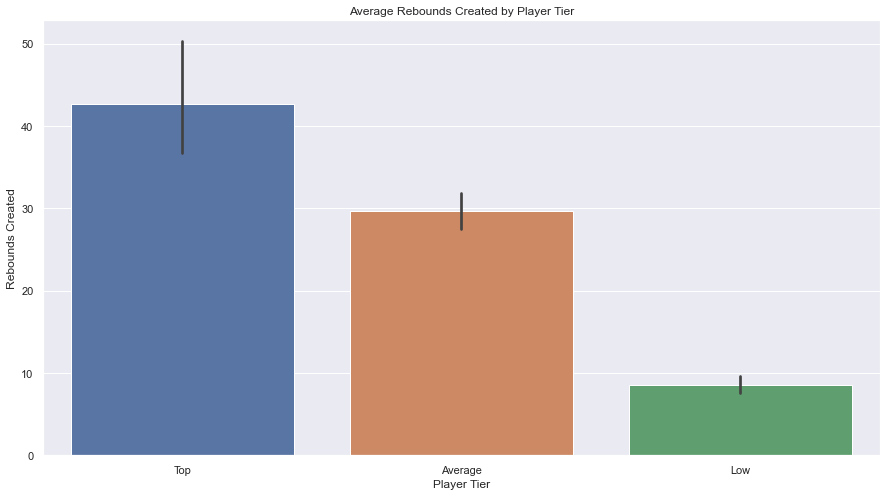

In [360]:
plt.figure(figsize=(15,8))
sns.barplot(data=defense, x='Player_Tier', y='Rebounds Created').set(title='Average Rebounds Created by Player Tier')
plt.xlabel('Player Tier')

Another interesting observation is that Top defenseman are creating more rebounds. As we could see from our correlation matrix earlier, rebounds created had a high correlation with Total Points. For defenseman, they take a lot of shots from "Low risk" areas of the ice. This means that statistically these shots are less likely to go in. But, these shots have a purpose other than scoring, generating rebounds. It is likely that if a defenseman is generating more rebounds one of their elite teammates could be there to put it into the net.

### Hits 

Text(0.5, 0, 'Player Tier')

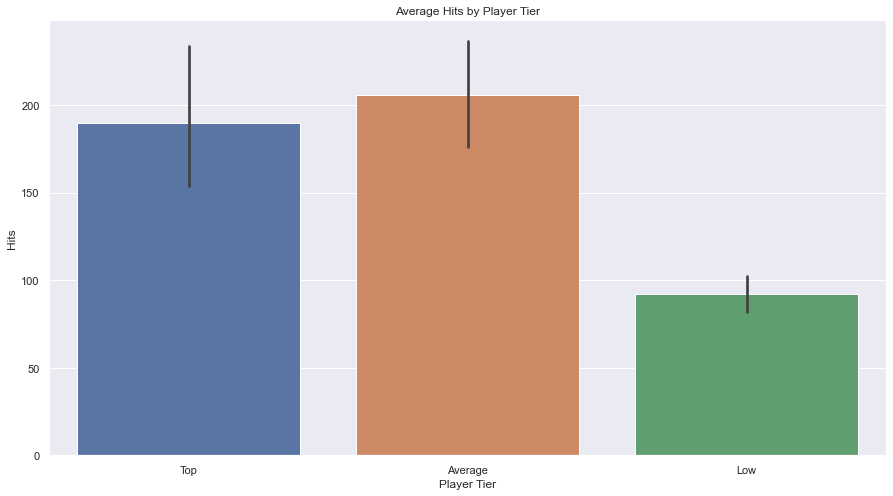

In [363]:
plt.figure(figsize=(15,8))
sns.barplot(data=defense, x='Player_Tier', y='Hits').set(title='Average Hits by Player Tier')
plt.xlabel('Player Tier')

 It is interesting to see that average defenseman are out hitting the top defenseman on average. This could be an indication that the top defenseman are focusing a bit less on the physical aspect of their position and thinking more offensively  

## Section 7 
### Conclusions

After analyzing these data sets I feel that I was able to make a strong case that corsi and fenwick, although interesting to think about, are not superior to the traditional shots on net statistics in predicting point production. I was able to show this not only visually with scatter plots but also regression modeling. I feel that when selecting players for a fantasy team a really important stat to pay attention to is how many shots a player is getting on net. 

I feel this was reinforced by the analysis of "Top" defenseman. They tend to on average out shoot the lower ranked defenseman. 

One limitation of this analysis is the fact I only looked at 5 on 5 play. A lot of points are generated on power plays. I felt though that since a majority of the game is played 5 on 5, in made sense to focus on even strength play

I had flirted with the idea of removing players with extremely low points totals or few games played. In the end I felt it was necessary to leave these players in to offset the high totals of the elite outliers

At the end of the day sports will continue to be heavily analyzed. Teams and their scouts are always going to be looking for ways to quantify a player's performance. But, like everything in life there are a lot of variables and some are extremely hard to measure. For example : team chemistry, mental toughness, puck luck, did the player eat to much before the game? etc. Although statistics can shine some light on how a player will perform, there will always be unknowns and to be honest, that is the beauty of the game.
 


